## Import libraries and MNIST dataset

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



## Define Convolutional Autoencoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
        
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## Initialize Loss function and the optimizer

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Train and evaluate model

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   


## Let's train!

	 partial train loss (single batch): 0.253115
	 partial train loss (single batch): 0.245432
	 partial train loss (single batch): 0.240480
	 partial train loss (single batch): 0.235943
	 partial train loss (single batch): 0.231731
	 partial train loss (single batch): 0.228051
	 partial train loss (single batch): 0.224990
	 partial train loss (single batch): 0.222399
	 partial train loss (single batch): 0.220462
	 partial train loss (single batch): 0.217796
	 partial train loss (single batch): 0.215640
	 partial train loss (single batch): 0.213329
	 partial train loss (single batch): 0.210727
	 partial train loss (single batch): 0.209123
	 partial train loss (single batch): 0.206965
	 partial train loss (single batch): 0.204888
	 partial train loss (single batch): 0.202693
	 partial train loss (single batch): 0.200546
	 partial train loss (single batch): 0.198519
	 partial train loss (single batch): 0.196792
	 partial train loss (single batch): 0.194683
	 partial train loss (single batch

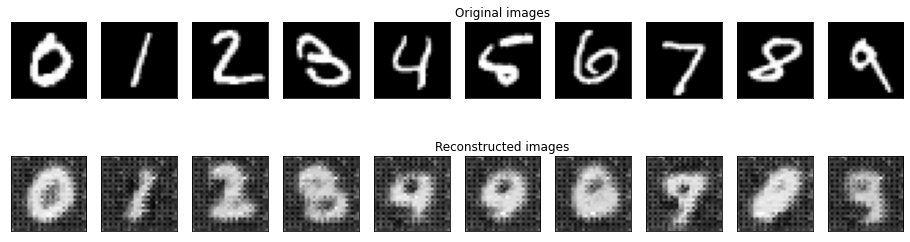

	 partial train loss (single batch): 0.065725
	 partial train loss (single batch): 0.067368
	 partial train loss (single batch): 0.065099
	 partial train loss (single batch): 0.065694
	 partial train loss (single batch): 0.065361
	 partial train loss (single batch): 0.065693
	 partial train loss (single batch): 0.065400
	 partial train loss (single batch): 0.064221
	 partial train loss (single batch): 0.061961
	 partial train loss (single batch): 0.063728
	 partial train loss (single batch): 0.063696
	 partial train loss (single batch): 0.064392
	 partial train loss (single batch): 0.063733
	 partial train loss (single batch): 0.063736
	 partial train loss (single batch): 0.062305
	 partial train loss (single batch): 0.063419
	 partial train loss (single batch): 0.062590
	 partial train loss (single batch): 0.062471
	 partial train loss (single batch): 0.062297
	 partial train loss (single batch): 0.062343
	 partial train loss (single batch): 0.061812
	 partial train loss (single batch

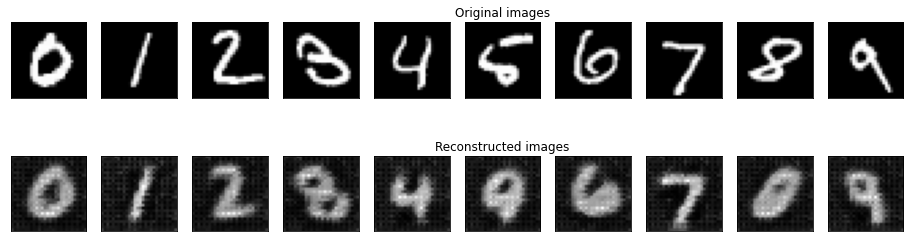

	 partial train loss (single batch): 0.045042
	 partial train loss (single batch): 0.047731
	 partial train loss (single batch): 0.044757
	 partial train loss (single batch): 0.045948
	 partial train loss (single batch): 0.046106
	 partial train loss (single batch): 0.046744
	 partial train loss (single batch): 0.046082
	 partial train loss (single batch): 0.045418
	 partial train loss (single batch): 0.042981
	 partial train loss (single batch): 0.044912
	 partial train loss (single batch): 0.045123
	 partial train loss (single batch): 0.046212
	 partial train loss (single batch): 0.046243
	 partial train loss (single batch): 0.045507
	 partial train loss (single batch): 0.044321
	 partial train loss (single batch): 0.046007
	 partial train loss (single batch): 0.044760
	 partial train loss (single batch): 0.044738
	 partial train loss (single batch): 0.044815
	 partial train loss (single batch): 0.045437
	 partial train loss (single batch): 0.044364
	 partial train loss (single batch

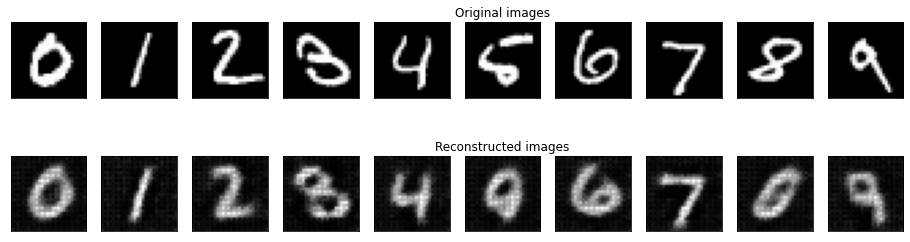

	 partial train loss (single batch): 0.036087
	 partial train loss (single batch): 0.039188
	 partial train loss (single batch): 0.035290
	 partial train loss (single batch): 0.036949
	 partial train loss (single batch): 0.037574
	 partial train loss (single batch): 0.037579
	 partial train loss (single batch): 0.037699
	 partial train loss (single batch): 0.036428
	 partial train loss (single batch): 0.034507
	 partial train loss (single batch): 0.035972
	 partial train loss (single batch): 0.036037
	 partial train loss (single batch): 0.038089
	 partial train loss (single batch): 0.038018
	 partial train loss (single batch): 0.036991
	 partial train loss (single batch): 0.036232
	 partial train loss (single batch): 0.037477
	 partial train loss (single batch): 0.036240
	 partial train loss (single batch): 0.036281
	 partial train loss (single batch): 0.036326
	 partial train loss (single batch): 0.037312
	 partial train loss (single batch): 0.035814
	 partial train loss (single batch

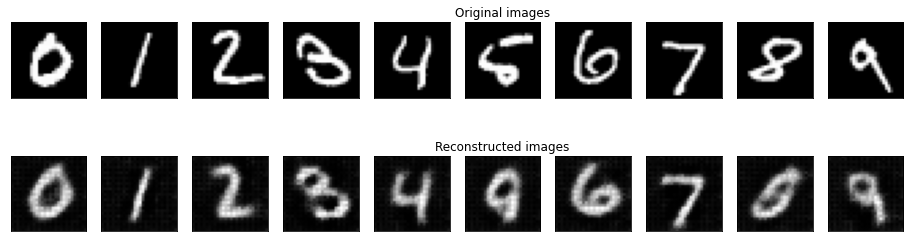

	 partial train loss (single batch): 0.032308
	 partial train loss (single batch): 0.035289
	 partial train loss (single batch): 0.031433
	 partial train loss (single batch): 0.033061
	 partial train loss (single batch): 0.033840
	 partial train loss (single batch): 0.033523
	 partial train loss (single batch): 0.033870
	 partial train loss (single batch): 0.032654
	 partial train loss (single batch): 0.030990
	 partial train loss (single batch): 0.032296
	 partial train loss (single batch): 0.032104
	 partial train loss (single batch): 0.034739
	 partial train loss (single batch): 0.034807
	 partial train loss (single batch): 0.033279
	 partial train loss (single batch): 0.032914
	 partial train loss (single batch): 0.033821
	 partial train loss (single batch): 0.032534
	 partial train loss (single batch): 0.032715
	 partial train loss (single batch): 0.032830
	 partial train loss (single batch): 0.033878
	 partial train loss (single batch): 0.032170
	 partial train loss (single batch

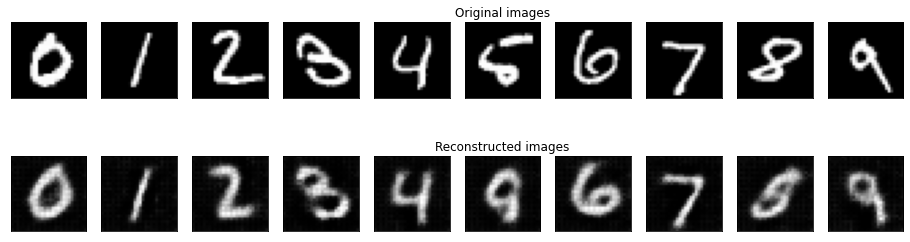

	 partial train loss (single batch): 0.030417
	 partial train loss (single batch): 0.033517
	 partial train loss (single batch): 0.029436
	 partial train loss (single batch): 0.031496
	 partial train loss (single batch): 0.032031
	 partial train loss (single batch): 0.031547
	 partial train loss (single batch): 0.031956
	 partial train loss (single batch): 0.030695
	 partial train loss (single batch): 0.029241
	 partial train loss (single batch): 0.030248
	 partial train loss (single batch): 0.030316
	 partial train loss (single batch): 0.032979
	 partial train loss (single batch): 0.033000
	 partial train loss (single batch): 0.031636
	 partial train loss (single batch): 0.031242
	 partial train loss (single batch): 0.031959
	 partial train loss (single batch): 0.030731
	 partial train loss (single batch): 0.031050
	 partial train loss (single batch): 0.031086
	 partial train loss (single batch): 0.032248
	 partial train loss (single batch): 0.030433
	 partial train loss (single batch

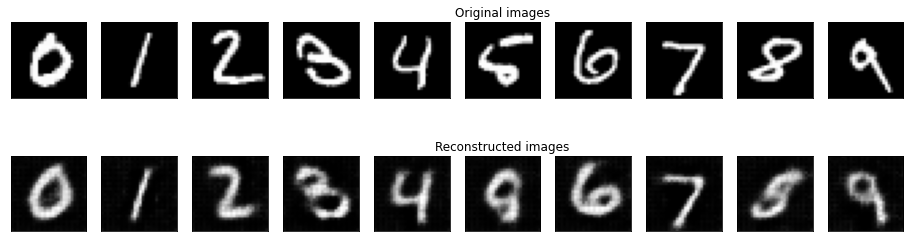

	 partial train loss (single batch): 0.029407
	 partial train loss (single batch): 0.032414
	 partial train loss (single batch): 0.028381
	 partial train loss (single batch): 0.030517
	 partial train loss (single batch): 0.031039
	 partial train loss (single batch): 0.030525
	 partial train loss (single batch): 0.030832
	 partial train loss (single batch): 0.029737
	 partial train loss (single batch): 0.028022
	 partial train loss (single batch): 0.029169
	 partial train loss (single batch): 0.029224
	 partial train loss (single batch): 0.032049
	 partial train loss (single batch): 0.032135
	 partial train loss (single batch): 0.030593
	 partial train loss (single batch): 0.030193
	 partial train loss (single batch): 0.030953
	 partial train loss (single batch): 0.029718
	 partial train loss (single batch): 0.030147
	 partial train loss (single batch): 0.029971
	 partial train loss (single batch): 0.031162
	 partial train loss (single batch): 0.029294
	 partial train loss (single batch

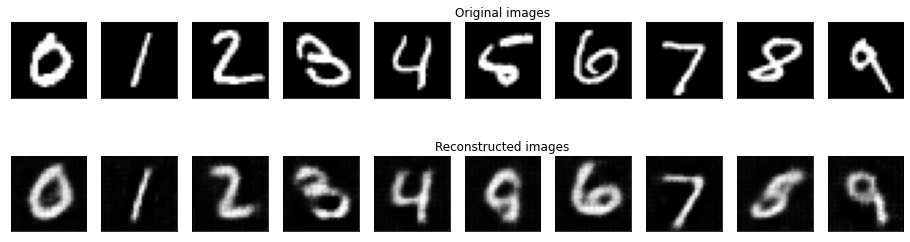

	 partial train loss (single batch): 0.028769
	 partial train loss (single batch): 0.031787
	 partial train loss (single batch): 0.027564
	 partial train loss (single batch): 0.029947
	 partial train loss (single batch): 0.030374
	 partial train loss (single batch): 0.029908
	 partial train loss (single batch): 0.029890
	 partial train loss (single batch): 0.029001
	 partial train loss (single batch): 0.027527
	 partial train loss (single batch): 0.028326
	 partial train loss (single batch): 0.028513
	 partial train loss (single batch): 0.031349
	 partial train loss (single batch): 0.031299
	 partial train loss (single batch): 0.029994
	 partial train loss (single batch): 0.029624
	 partial train loss (single batch): 0.030194
	 partial train loss (single batch): 0.028958
	 partial train loss (single batch): 0.029452
	 partial train loss (single batch): 0.029320
	 partial train loss (single batch): 0.030470
	 partial train loss (single batch): 0.028635
	 partial train loss (single batch

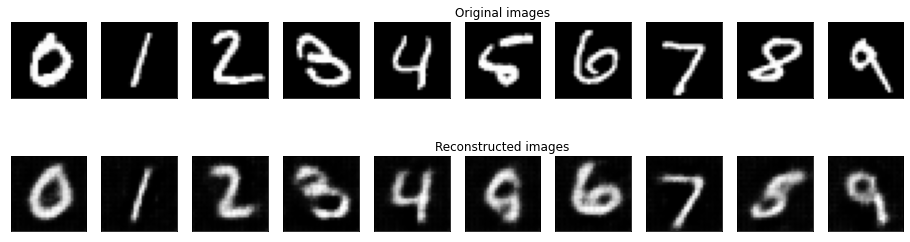

	 partial train loss (single batch): 0.028150
	 partial train loss (single batch): 0.031114
	 partial train loss (single batch): 0.026935
	 partial train loss (single batch): 0.029525
	 partial train loss (single batch): 0.029917
	 partial train loss (single batch): 0.029299
	 partial train loss (single batch): 0.029317
	 partial train loss (single batch): 0.028331
	 partial train loss (single batch): 0.027130
	 partial train loss (single batch): 0.027832
	 partial train loss (single batch): 0.027862
	 partial train loss (single batch): 0.030782
	 partial train loss (single batch): 0.030669
	 partial train loss (single batch): 0.029347
	 partial train loss (single batch): 0.029009
	 partial train loss (single batch): 0.029563
	 partial train loss (single batch): 0.028345
	 partial train loss (single batch): 0.028919
	 partial train loss (single batch): 0.028743
	 partial train loss (single batch): 0.030036
	 partial train loss (single batch): 0.028037
	 partial train loss (single batch

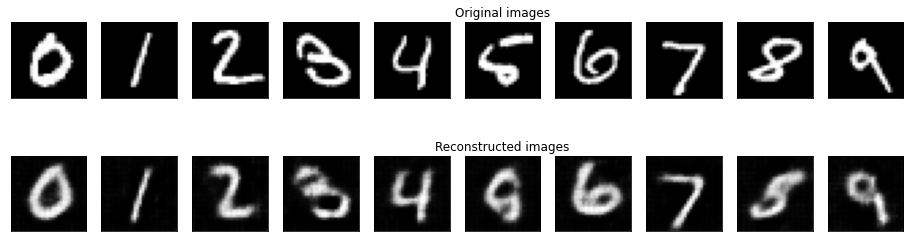

	 partial train loss (single batch): 0.027751
	 partial train loss (single batch): 0.030645
	 partial train loss (single batch): 0.026574
	 partial train loss (single batch): 0.029148
	 partial train loss (single batch): 0.029524
	 partial train loss (single batch): 0.028933
	 partial train loss (single batch): 0.028976
	 partial train loss (single batch): 0.027978
	 partial train loss (single batch): 0.026694
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch): 0.027387
	 partial train loss (single batch): 0.030449
	 partial train loss (single batch): 0.030195
	 partial train loss (single batch): 0.028879
	 partial train loss (single batch): 0.028534
	 partial train loss (single batch): 0.029043
	 partial train loss (single batch): 0.027803
	 partial train loss (single batch): 0.028548
	 partial train loss (single batch): 0.028278
	 partial train loss (single batch): 0.029549
	 partial train loss (single batch): 0.027699
	 partial train loss (single batch

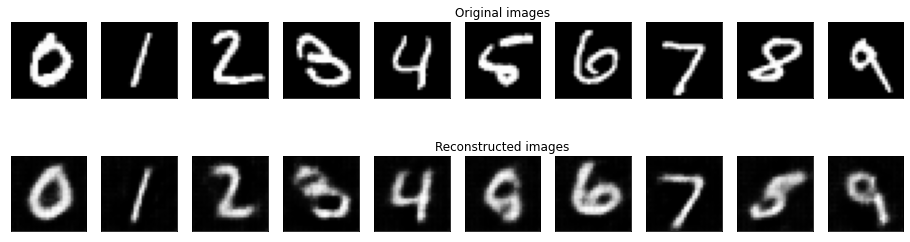

	 partial train loss (single batch): 0.027360
	 partial train loss (single batch): 0.030197
	 partial train loss (single batch): 0.026150
	 partial train loss (single batch): 0.028841
	 partial train loss (single batch): 0.029087
	 partial train loss (single batch): 0.028516
	 partial train loss (single batch): 0.028606
	 partial train loss (single batch): 0.027634
	 partial train loss (single batch): 0.026344
	 partial train loss (single batch): 0.027045
	 partial train loss (single batch): 0.026937
	 partial train loss (single batch): 0.030103
	 partial train loss (single batch): 0.029789
	 partial train loss (single batch): 0.028505
	 partial train loss (single batch): 0.028105
	 partial train loss (single batch): 0.028746
	 partial train loss (single batch): 0.027360
	 partial train loss (single batch): 0.028251
	 partial train loss (single batch): 0.027870
	 partial train loss (single batch): 0.029121
	 partial train loss (single batch): 0.027383
	 partial train loss (single batch

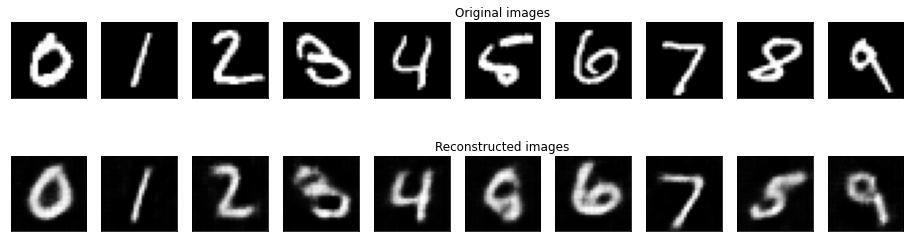

	 partial train loss (single batch): 0.027039
	 partial train loss (single batch): 0.029873
	 partial train loss (single batch): 0.025850
	 partial train loss (single batch): 0.028646
	 partial train loss (single batch): 0.028855
	 partial train loss (single batch): 0.028292
	 partial train loss (single batch): 0.028326
	 partial train loss (single batch): 0.027210
	 partial train loss (single batch): 0.026086
	 partial train loss (single batch): 0.026688
	 partial train loss (single batch): 0.026511
	 partial train loss (single batch): 0.029823
	 partial train loss (single batch): 0.029473
	 partial train loss (single batch): 0.028268
	 partial train loss (single batch): 0.027784
	 partial train loss (single batch): 0.028528
	 partial train loss (single batch): 0.026992
	 partial train loss (single batch): 0.027979
	 partial train loss (single batch): 0.027505
	 partial train loss (single batch): 0.028772
	 partial train loss (single batch): 0.027226
	 partial train loss (single batch

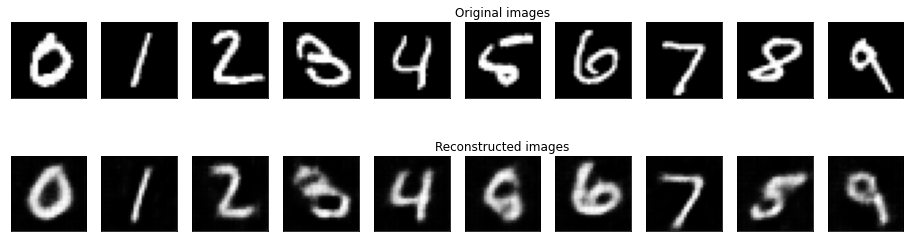

	 partial train loss (single batch): 0.026917
	 partial train loss (single batch): 0.029528
	 partial train loss (single batch): 0.025635
	 partial train loss (single batch): 0.028493
	 partial train loss (single batch): 0.028687
	 partial train loss (single batch): 0.028078
	 partial train loss (single batch): 0.028050
	 partial train loss (single batch): 0.026898
	 partial train loss (single batch): 0.025836
	 partial train loss (single batch): 0.026448
	 partial train loss (single batch): 0.026223
	 partial train loss (single batch): 0.029534
	 partial train loss (single batch): 0.029162
	 partial train loss (single batch): 0.028077
	 partial train loss (single batch): 0.027497
	 partial train loss (single batch): 0.028329
	 partial train loss (single batch): 0.026687
	 partial train loss (single batch): 0.027849
	 partial train loss (single batch): 0.027049
	 partial train loss (single batch): 0.028485
	 partial train loss (single batch): 0.027079
	 partial train loss (single batch

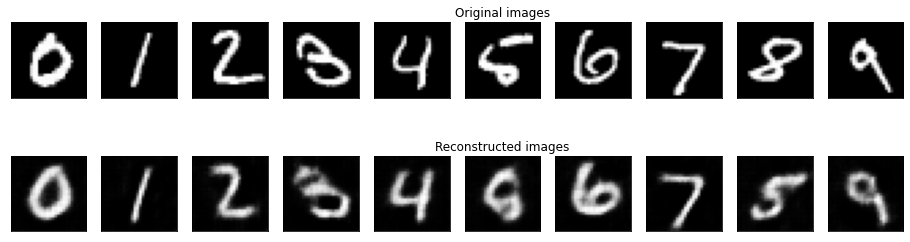

	 partial train loss (single batch): 0.026735
	 partial train loss (single batch): 0.029189
	 partial train loss (single batch): 0.025361
	 partial train loss (single batch): 0.028191
	 partial train loss (single batch): 0.028376
	 partial train loss (single batch): 0.027861
	 partial train loss (single batch): 0.027791
	 partial train loss (single batch): 0.026605
	 partial train loss (single batch): 0.025534
	 partial train loss (single batch): 0.026198
	 partial train loss (single batch): 0.025947
	 partial train loss (single batch): 0.029319
	 partial train loss (single batch): 0.028935
	 partial train loss (single batch): 0.027869
	 partial train loss (single batch): 0.027175
	 partial train loss (single batch): 0.028062
	 partial train loss (single batch): 0.026442
	 partial train loss (single batch): 0.027596
	 partial train loss (single batch): 0.026716
	 partial train loss (single batch): 0.028245
	 partial train loss (single batch): 0.026855
	 partial train loss (single batch

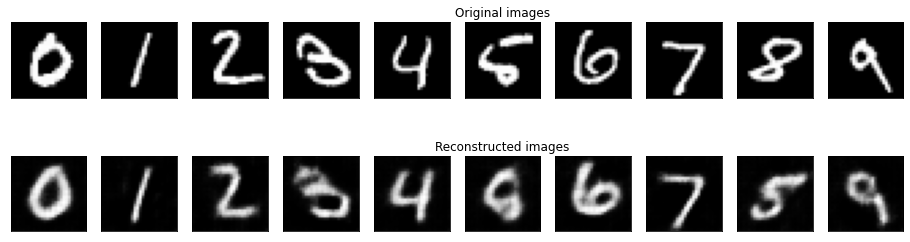

	 partial train loss (single batch): 0.026483
	 partial train loss (single batch): 0.028990
	 partial train loss (single batch): 0.025079
	 partial train loss (single batch): 0.027966
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.027666
	 partial train loss (single batch): 0.027617
	 partial train loss (single batch): 0.026398
	 partial train loss (single batch): 0.025346
	 partial train loss (single batch): 0.026114
	 partial train loss (single batch): 0.025752
	 partial train loss (single batch): 0.029124
	 partial train loss (single batch): 0.028769
	 partial train loss (single batch): 0.027621
	 partial train loss (single batch): 0.027006
	 partial train loss (single batch): 0.027802
	 partial train loss (single batch): 0.026223
	 partial train loss (single batch): 0.027486
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.028051
	 partial train loss (single batch): 0.026714
	 partial train loss (single batch

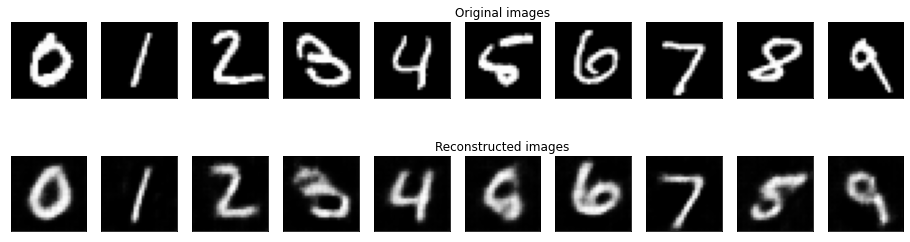

	 partial train loss (single batch): 0.026235
	 partial train loss (single batch): 0.028814
	 partial train loss (single batch): 0.024894
	 partial train loss (single batch): 0.027720
	 partial train loss (single batch): 0.028025
	 partial train loss (single batch): 0.027471
	 partial train loss (single batch): 0.027451
	 partial train loss (single batch): 0.026256
	 partial train loss (single batch): 0.025145
	 partial train loss (single batch): 0.025899
	 partial train loss (single batch): 0.025509
	 partial train loss (single batch): 0.028954
	 partial train loss (single batch): 0.028531
	 partial train loss (single batch): 0.027328
	 partial train loss (single batch): 0.026884
	 partial train loss (single batch): 0.027652
	 partial train loss (single batch): 0.026122
	 partial train loss (single batch): 0.027312
	 partial train loss (single batch): 0.026306
	 partial train loss (single batch): 0.027783
	 partial train loss (single batch): 0.026526
	 partial train loss (single batch

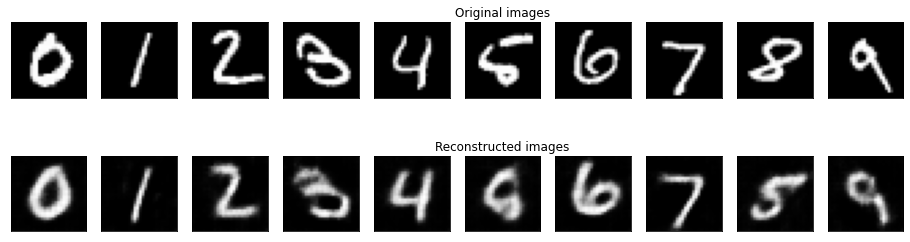

	 partial train loss (single batch): 0.026048
	 partial train loss (single batch): 0.028637
	 partial train loss (single batch): 0.024706
	 partial train loss (single batch): 0.027579
	 partial train loss (single batch): 0.027812
	 partial train loss (single batch): 0.027340
	 partial train loss (single batch): 0.027292
	 partial train loss (single batch): 0.026029
	 partial train loss (single batch): 0.024890
	 partial train loss (single batch): 0.025750
	 partial train loss (single batch): 0.025358
	 partial train loss (single batch): 0.028778
	 partial train loss (single batch): 0.028332
	 partial train loss (single batch): 0.027145
	 partial train loss (single batch): 0.026732
	 partial train loss (single batch): 0.027521
	 partial train loss (single batch): 0.025999
	 partial train loss (single batch): 0.027156
	 partial train loss (single batch): 0.026097
	 partial train loss (single batch): 0.027637
	 partial train loss (single batch): 0.026361
	 partial train loss (single batch

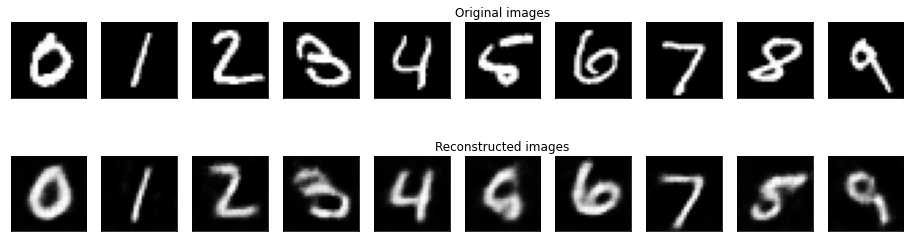

	 partial train loss (single batch): 0.025934
	 partial train loss (single batch): 0.028403
	 partial train loss (single batch): 0.024502
	 partial train loss (single batch): 0.027409
	 partial train loss (single batch): 0.027616
	 partial train loss (single batch): 0.027094
	 partial train loss (single batch): 0.027068
	 partial train loss (single batch): 0.025867
	 partial train loss (single batch): 0.024688
	 partial train loss (single batch): 0.025572
	 partial train loss (single batch): 0.025190
	 partial train loss (single batch): 0.028454
	 partial train loss (single batch): 0.028223
	 partial train loss (single batch): 0.026985
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.027332
	 partial train loss (single batch): 0.025869
	 partial train loss (single batch): 0.027065
	 partial train loss (single batch): 0.025874
	 partial train loss (single batch): 0.027513
	 partial train loss (single batch): 0.026178
	 partial train loss (single batch

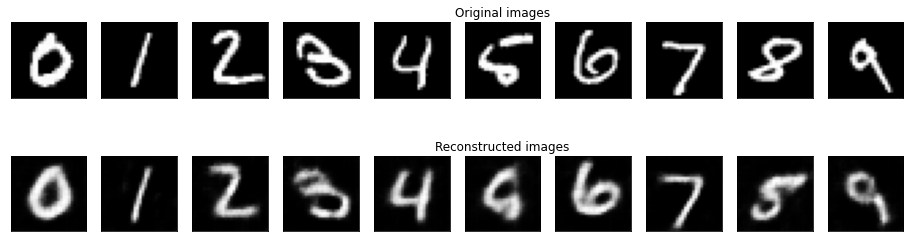

	 partial train loss (single batch): 0.025816
	 partial train loss (single batch): 0.028190
	 partial train loss (single batch): 0.024413
	 partial train loss (single batch): 0.027383
	 partial train loss (single batch): 0.027398
	 partial train loss (single batch): 0.026992
	 partial train loss (single batch): 0.026996
	 partial train loss (single batch): 0.025818
	 partial train loss (single batch): 0.024556
	 partial train loss (single batch): 0.025424
	 partial train loss (single batch): 0.024989
	 partial train loss (single batch): 0.028268
	 partial train loss (single batch): 0.028058
	 partial train loss (single batch): 0.026867
	 partial train loss (single batch): 0.026500
	 partial train loss (single batch): 0.027202
	 partial train loss (single batch): 0.025742
	 partial train loss (single batch): 0.026923
	 partial train loss (single batch): 0.025758
	 partial train loss (single batch): 0.027343
	 partial train loss (single batch): 0.026090
	 partial train loss (single batch

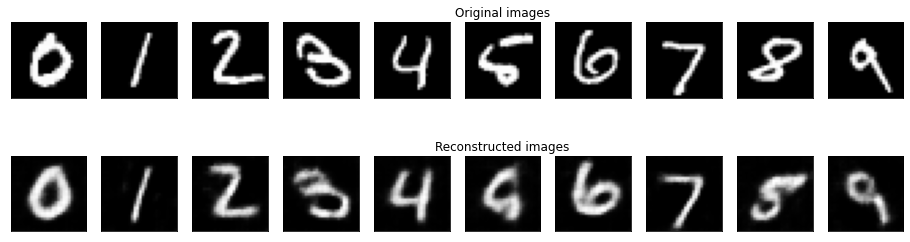

	 partial train loss (single batch): 0.025623
	 partial train loss (single batch): 0.027998
	 partial train loss (single batch): 0.024270
	 partial train loss (single batch): 0.027298
	 partial train loss (single batch): 0.027326
	 partial train loss (single batch): 0.026849
	 partial train loss (single batch): 0.026762
	 partial train loss (single batch): 0.025727
	 partial train loss (single batch): 0.024431
	 partial train loss (single batch): 0.025440
	 partial train loss (single batch): 0.024850
	 partial train loss (single batch): 0.028136
	 partial train loss (single batch): 0.027924
	 partial train loss (single batch): 0.026639
	 partial train loss (single batch): 0.026284
	 partial train loss (single batch): 0.027029
	 partial train loss (single batch): 0.025625
	 partial train loss (single batch): 0.026704
	 partial train loss (single batch): 0.025588
	 partial train loss (single batch): 0.027200
	 partial train loss (single batch): 0.025903
	 partial train loss (single batch

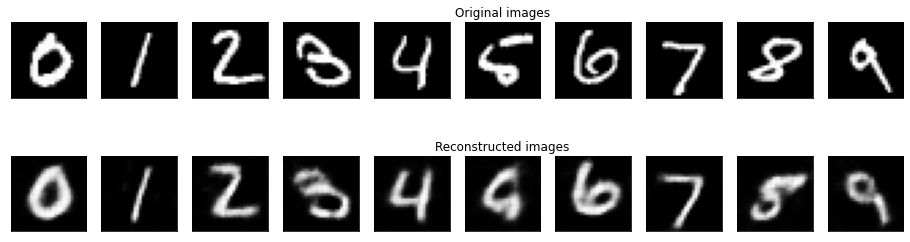

	 partial train loss (single batch): 0.025574
	 partial train loss (single batch): 0.027821
	 partial train loss (single batch): 0.024173
	 partial train loss (single batch): 0.027110
	 partial train loss (single batch): 0.027147
	 partial train loss (single batch): 0.026822
	 partial train loss (single batch): 0.026692
	 partial train loss (single batch): 0.025722
	 partial train loss (single batch): 0.024339
	 partial train loss (single batch): 0.025288
	 partial train loss (single batch): 0.024812
	 partial train loss (single batch): 0.028054
	 partial train loss (single batch): 0.027753
	 partial train loss (single batch): 0.026570
	 partial train loss (single batch): 0.026252
	 partial train loss (single batch): 0.026906
	 partial train loss (single batch): 0.025421
	 partial train loss (single batch): 0.026556
	 partial train loss (single batch): 0.025546
	 partial train loss (single batch): 0.027119
	 partial train loss (single batch): 0.025839
	 partial train loss (single batch

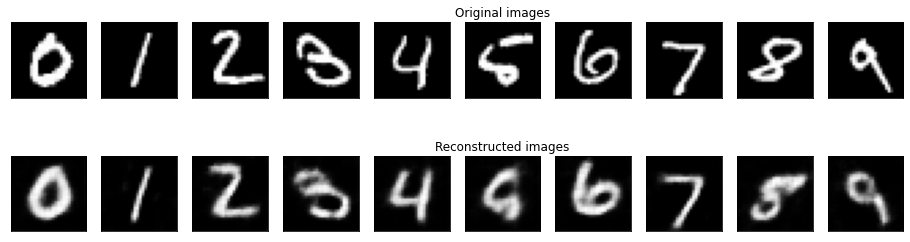

	 partial train loss (single batch): 0.025495
	 partial train loss (single batch): 0.027627
	 partial train loss (single batch): 0.024190
	 partial train loss (single batch): 0.027069
	 partial train loss (single batch): 0.026909
	 partial train loss (single batch): 0.026774
	 partial train loss (single batch): 0.026661
	 partial train loss (single batch): 0.025628
	 partial train loss (single batch): 0.024260
	 partial train loss (single batch): 0.025278
	 partial train loss (single batch): 0.024784
	 partial train loss (single batch): 0.027857
	 partial train loss (single batch): 0.027682
	 partial train loss (single batch): 0.026453
	 partial train loss (single batch): 0.026313
	 partial train loss (single batch): 0.026732
	 partial train loss (single batch): 0.025305
	 partial train loss (single batch): 0.026611
	 partial train loss (single batch): 0.025402
	 partial train loss (single batch): 0.027061
	 partial train loss (single batch): 0.025748
	 partial train loss (single batch

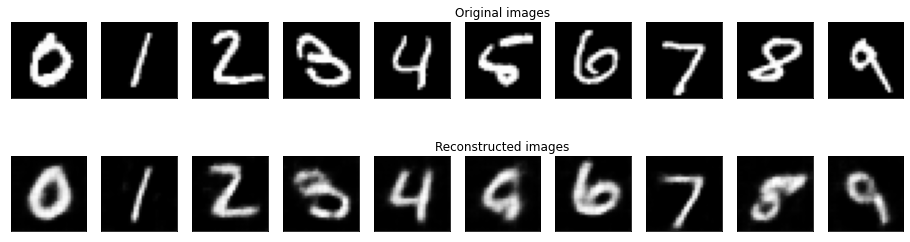

	 partial train loss (single batch): 0.025453
	 partial train loss (single batch): 0.027503
	 partial train loss (single batch): 0.024091
	 partial train loss (single batch): 0.027052
	 partial train loss (single batch): 0.026769
	 partial train loss (single batch): 0.026666
	 partial train loss (single batch): 0.026578
	 partial train loss (single batch): 0.025505
	 partial train loss (single batch): 0.024277
	 partial train loss (single batch): 0.025192
	 partial train loss (single batch): 0.024677
	 partial train loss (single batch): 0.027719
	 partial train loss (single batch): 0.027676
	 partial train loss (single batch): 0.026320
	 partial train loss (single batch): 0.026281
	 partial train loss (single batch): 0.026738
	 partial train loss (single batch): 0.025149
	 partial train loss (single batch): 0.026608
	 partial train loss (single batch): 0.025395
	 partial train loss (single batch): 0.026892
	 partial train loss (single batch): 0.025694
	 partial train loss (single batch

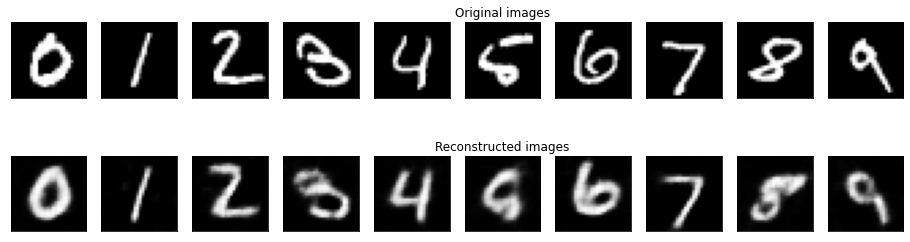

	 partial train loss (single batch): 0.025291
	 partial train loss (single batch): 0.027439
	 partial train loss (single batch): 0.023991
	 partial train loss (single batch): 0.026966
	 partial train loss (single batch): 0.026568
	 partial train loss (single batch): 0.026478
	 partial train loss (single batch): 0.026529
	 partial train loss (single batch): 0.025357
	 partial train loss (single batch): 0.024078
	 partial train loss (single batch): 0.025131
	 partial train loss (single batch): 0.024616
	 partial train loss (single batch): 0.027569
	 partial train loss (single batch): 0.027568
	 partial train loss (single batch): 0.026234
	 partial train loss (single batch): 0.026249
	 partial train loss (single batch): 0.026607
	 partial train loss (single batch): 0.025024
	 partial train loss (single batch): 0.026460
	 partial train loss (single batch): 0.025403
	 partial train loss (single batch): 0.026780
	 partial train loss (single batch): 0.025654
	 partial train loss (single batch

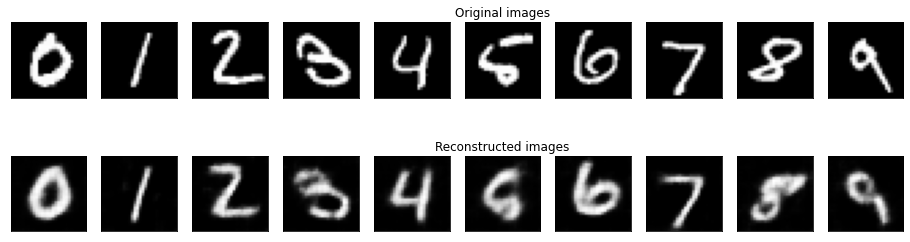

	 partial train loss (single batch): 0.025227
	 partial train loss (single batch): 0.027276
	 partial train loss (single batch): 0.023935
	 partial train loss (single batch): 0.026829
	 partial train loss (single batch): 0.026494
	 partial train loss (single batch): 0.026451
	 partial train loss (single batch): 0.026387
	 partial train loss (single batch): 0.025278
	 partial train loss (single batch): 0.024005
	 partial train loss (single batch): 0.025004
	 partial train loss (single batch): 0.024480
	 partial train loss (single batch): 0.027456
	 partial train loss (single batch): 0.027349
	 partial train loss (single batch): 0.026123
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.026447
	 partial train loss (single batch): 0.024934
	 partial train loss (single batch): 0.026379
	 partial train loss (single batch): 0.025293
	 partial train loss (single batch): 0.026738
	 partial train loss (single batch): 0.025599
	 partial train loss (single batch

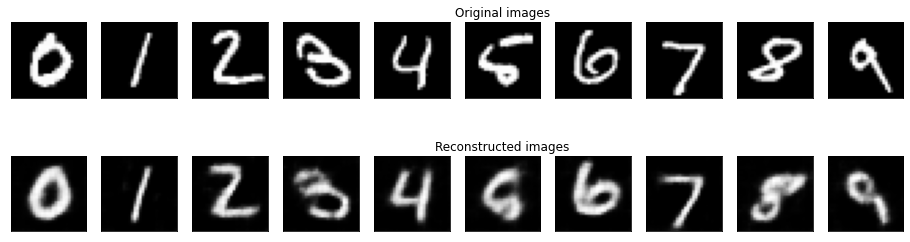

	 partial train loss (single batch): 0.025071
	 partial train loss (single batch): 0.027138
	 partial train loss (single batch): 0.023855
	 partial train loss (single batch): 0.026723
	 partial train loss (single batch): 0.026365
	 partial train loss (single batch): 0.026384
	 partial train loss (single batch): 0.026323
	 partial train loss (single batch): 0.025229
	 partial train loss (single batch): 0.023913
	 partial train loss (single batch): 0.024886
	 partial train loss (single batch): 0.024377
	 partial train loss (single batch): 0.027367
	 partial train loss (single batch): 0.027186
	 partial train loss (single batch): 0.026046
	 partial train loss (single batch): 0.026040
	 partial train loss (single batch): 0.026351
	 partial train loss (single batch): 0.024819
	 partial train loss (single batch): 0.026159
	 partial train loss (single batch): 0.025155
	 partial train loss (single batch): 0.026596
	 partial train loss (single batch): 0.025466
	 partial train loss (single batch

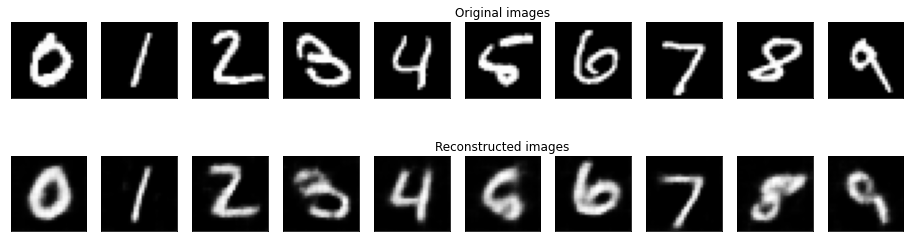

	 partial train loss (single batch): 0.024947
	 partial train loss (single batch): 0.027037
	 partial train loss (single batch): 0.023723
	 partial train loss (single batch): 0.026592
	 partial train loss (single batch): 0.026335
	 partial train loss (single batch): 0.026301
	 partial train loss (single batch): 0.026217
	 partial train loss (single batch): 0.025146
	 partial train loss (single batch): 0.023798
	 partial train loss (single batch): 0.024885
	 partial train loss (single batch): 0.024355
	 partial train loss (single batch): 0.027303
	 partial train loss (single batch): 0.027174
	 partial train loss (single batch): 0.025953
	 partial train loss (single batch): 0.025963
	 partial train loss (single batch): 0.026326
	 partial train loss (single batch): 0.024790
	 partial train loss (single batch): 0.026156
	 partial train loss (single batch): 0.025053
	 partial train loss (single batch): 0.026566
	 partial train loss (single batch): 0.025443
	 partial train loss (single batch

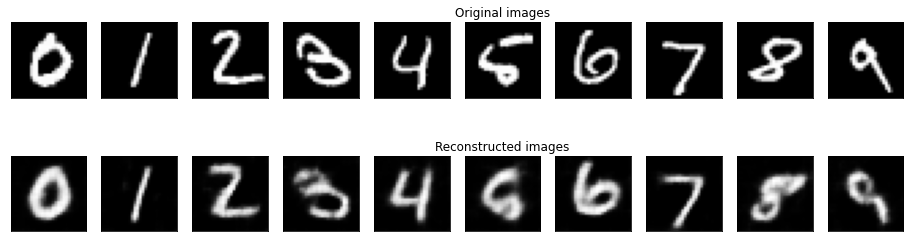

	 partial train loss (single batch): 0.024893
	 partial train loss (single batch): 0.026929
	 partial train loss (single batch): 0.023628
	 partial train loss (single batch): 0.026534
	 partial train loss (single batch): 0.026241
	 partial train loss (single batch): 0.026285
	 partial train loss (single batch): 0.026172
	 partial train loss (single batch): 0.025116
	 partial train loss (single batch): 0.023703
	 partial train loss (single batch): 0.024760
	 partial train loss (single batch): 0.024178
	 partial train loss (single batch): 0.027247
	 partial train loss (single batch): 0.027119
	 partial train loss (single batch): 0.025876
	 partial train loss (single batch): 0.025911
	 partial train loss (single batch): 0.026198
	 partial train loss (single batch): 0.024756
	 partial train loss (single batch): 0.025973
	 partial train loss (single batch): 0.024932
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.025417
	 partial train loss (single batch

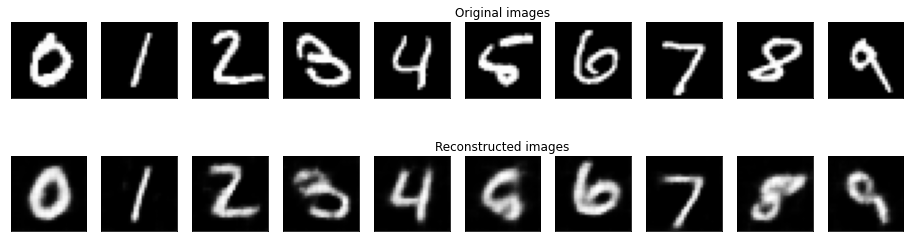

	 partial train loss (single batch): 0.024851
	 partial train loss (single batch): 0.026844
	 partial train loss (single batch): 0.023547
	 partial train loss (single batch): 0.026413
	 partial train loss (single batch): 0.026223
	 partial train loss (single batch): 0.026189
	 partial train loss (single batch): 0.026097
	 partial train loss (single batch): 0.025037
	 partial train loss (single batch): 0.023674
	 partial train loss (single batch): 0.024722
	 partial train loss (single batch): 0.024193
	 partial train loss (single batch): 0.027172
	 partial train loss (single batch): 0.027033
	 partial train loss (single batch): 0.025828
	 partial train loss (single batch): 0.025900
	 partial train loss (single batch): 0.026085
	 partial train loss (single batch): 0.024705
	 partial train loss (single batch): 0.025896
	 partial train loss (single batch): 0.024778
	 partial train loss (single batch): 0.026355
	 partial train loss (single batch): 0.025345
	 partial train loss (single batch

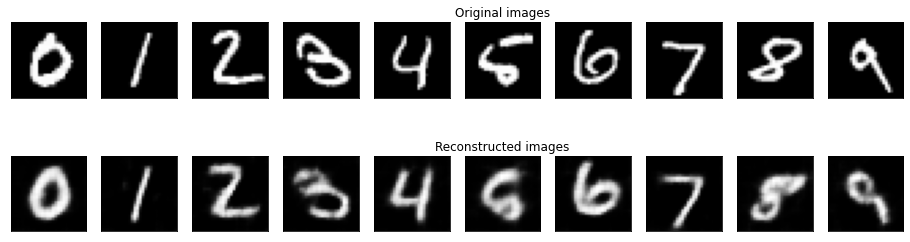

	 partial train loss (single batch): 0.024748
	 partial train loss (single batch): 0.026631
	 partial train loss (single batch): 0.023455
	 partial train loss (single batch): 0.026370
	 partial train loss (single batch): 0.026085
	 partial train loss (single batch): 0.026182
	 partial train loss (single batch): 0.026030
	 partial train loss (single batch): 0.025042
	 partial train loss (single batch): 0.023632
	 partial train loss (single batch): 0.024599
	 partial train loss (single batch): 0.024150
	 partial train loss (single batch): 0.027221
	 partial train loss (single batch): 0.026911
	 partial train loss (single batch): 0.025804
	 partial train loss (single batch): 0.025890
	 partial train loss (single batch): 0.026118
	 partial train loss (single batch): 0.024709
	 partial train loss (single batch): 0.025882
	 partial train loss (single batch): 0.024745
	 partial train loss (single batch): 0.026214
	 partial train loss (single batch): 0.025257
	 partial train loss (single batch

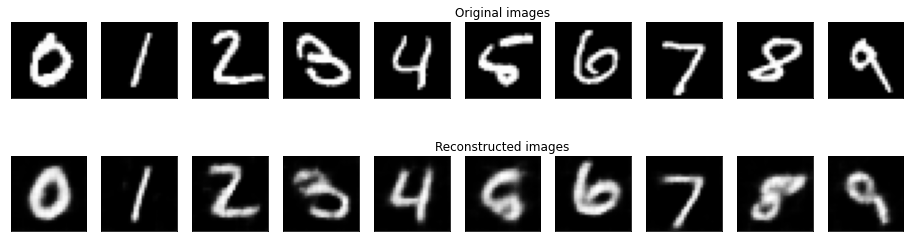

In [ ]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)


## 

## Final evaluations

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02624059095978737

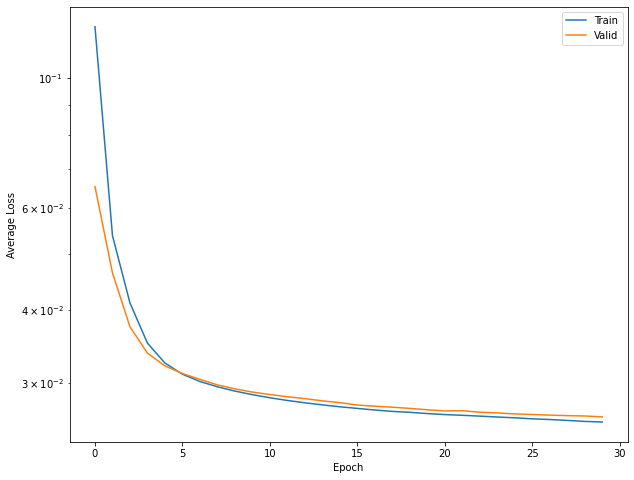

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()


In [ ]:
torch.save(encoder, "./encoder")
torch.save(decoder, "./decoder")

In [ ]:
torch.save(encoder.state_dict(), "encoder.pt")
torch.save(decoder.state_dict(), "decoder.pt")